# CatBoost: Train & Evaluate

This notebook provides a minimal, reproducible pipeline to train and evaluate a CatBoost model.

Fill in `DATA_PATH` and `TARGET_COLUMN` below, then run cells in order.


## Usage

- Set `DATA_PATH` to your CSV path (kept empty by default).
- Set `TARGET_COLUMN` to your label column.
- Optionally set `ID_COLUMNS` to drop identifier columns.
- Choose `TASK_TYPE` = 'classification' or 'regression'.


In [136]:
# If CatBoost is not installed in your environment, uncomment to install
# %pip install --quiet --upgrade catboost

In [137]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, classification_report,
    mean_absolute_error, root_mean_squared_error, r2_score,
    confusion_matrix, precision_recall_curve, average_precision_score,
    ConfusionMatrixDisplay
)

# Plotting
import matplotlib.pyplot as plt

# CatBoost
from catboost import CatBoostClassifier, CatBoostRegressor


In [138]:
# ==== Configuration (edit these) ====
# DATA_PATH = "../data/training/final/travel_ml.csv"  # path to your CSV (left empty intentionally)
DATA_PATH = "../data/training/final/travel_cat.csv"  # path to your CSV (left empty intentionally)
TARGET_COLUMN = "IS_FAILED_TRIP"  # name of the target column to predict
TASK_TYPE = "classification"  # 'classification' or 'regression'
ID_COLUMNS = []     # optional columns to drop (e.g., unique IDs)

# Class imbalance handling (classification only)
# Default: auto-balance to avoid all-zero predictions on imbalanced data.
IMBALANCE_MODE = "auto_balanced"  # 'none' | 'auto_balanced' | 'manual'
MANUAL_CLASS_WEIGHTS = None  # e.g., {0: 1.0, 1: 2.3}

# Threshold tuning for binary classification
# Options: 'none', 'f1', 'f05', 'precision_at'
THRESHOLD_TUNING = 'f1'
TARGET_PRECISION = 0.80  # used when THRESHOLD_TUNING == 'precision_at'

# Train/validation split & reproducibility
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Outputs for plots
OUTPUT_DIR = "outputs/01_Catboost"
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [139]:
# ==== Load data ====
if not DATA_PATH or not TARGET_COLUMN:
    raise ValueError(
        "Please set DATA_PATH and TARGET_COLUMN to your dataset CSV path and target column name."
    )

df = pd.read_csv(DATA_PATH)
print(f"Loaded: {DATA_PATH}")
print(f"Shape: {df.shape}")
display(df.head())

nulls = df.isnull().sum().sort_values(ascending=False)
print("Top null counts:")
display(nulls.head(10))


Loaded: ../data/training/final/travel_cat.csv
Shape: (5130, 48)


,TRAVEL_ID,TRAVEL_PURPOSE,TRAVEL_START_YMD,TRAVEL_END_YMD,MVMN_NM,TRAVEL_MISSION_CHECK,activity_payment_sum,activity_payment_count,activity_store_count,activity_history_rows,...,TRAVEL_STATUS_RESIDENCE_CODE,TRAVEL_STATUS_DESTINATION_CODE,activity_per_day,spending_per_day,activity_to_lodging_ratio,companions_per_family,TRAVEL_START_YEAR,TRAVEL_START_MONTH,TRAVEL_END_YEAR,TRAVEL_END_MONTH
0,a_a014262,1;11;2;22;,2022-10-29,2022-10-30,자가용,2;1;22,183249,6,6,5,...,11.0,41.0,3.00,151124.5,1.539895,0.333333,2022,10,2022,10
1,a_a006728,21;24;5;22;26;27;,2022-10-10,2022-10-11,자가용,6;1;22,68600,3,3,10,...,11.0,41.0,1.50,93800.0,0.576466,0.750000,2022,10,2022,10
2,a_a015745,1;2;6;,2022-10-31,2022-11-03,대중교통 등,13;3;28,57100,7,6,22,...,11.0,28.0,1.75,44025.0,0.479828,0.000000,2022,10,2022,11
3,a_a010544,21;22;24;26;,2022-11-01,2022-11-02,자가용,1;22;26,89700,5,4,10,...,11.0,41.0,2.50,104350.0,0.753775,0.000000,2022,11,2022,11
4,a_a012058,1;4;10;12;21;22;26;,2022-11-05,2022-11-06,대중교통 등,1;21;22,155520,4,4,8,...,42.0,41.0,4.00,274520.0,1.306880,0.500000,2022,11,2022,11


Top null counts:


TRAVEL_ID                 0
TRAVEL_PURPOSE            0
TRAVEL_START_YMD          0
TRAVEL_END_YMD            0
MVMN_NM                   0
TRAVEL_MISSION_CHECK      0
activity_payment_sum      0
activity_payment_count    0
activity_store_count      0
activity_history_rows     0
dtype: int64

In [140]:
# ==== Prepare features/target ====
drop_cols = [c for c in [TARGET_COLUMN, *ID_COLUMNS] if c in df.columns]
X = df.drop(columns=drop_cols)
y = df[TARGET_COLUMN]

# Detect categorical columns by dtype
categorical_cols = [
    c for c in X.columns
    if (X[c].dtype == 'object') or (str(X[c].dtype).startswith('category'))
]
cat_features = [X.columns.get_loc(c) for c in categorical_cols]

print(f"Features: {X.shape[1]} | Rows: {X.shape[0]}")
print(f"Categorical features detected: {len(cat_features)}")
if categorical_cols:
    print("Sample categorical columns:", categorical_cols[:10])


Features: 47 | Rows: 5130
Categorical features detected: 10
Sample categorical columns: ['TRAVEL_ID', 'TRAVEL_PURPOSE', 'TRAVEL_START_YMD', 'TRAVEL_END_YMD', 'MVMN_NM', 'TRAVEL_MISSION_CHECK', 'GENDER', 'TRAVEL_STATUS_RESIDENCE', 'TRAVEL_STATUS_DESTINATION', 'TRAVEL_STATUS_ACCOMPANY']


In [141]:
# ==== Train/Validation split ====
use_stratify = (TASK_TYPE == 'classification') and (y.nunique() > 1)
stratify = y if use_stratify else None

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=stratify
)
print("Train shapes:", X_train.shape, y_train.shape)
print("Valid shapes:", X_valid.shape, y_valid.shape)


Train shapes: (4104, 47) (4104,)
Valid shapes: (1026, 47) (1026,)


In [142]:
# ==== Train CatBoost model with imbalance options ====
if TASK_TYPE == 'classification':
    is_binary = y.nunique() == 2
    params = dict(
        iterations=2000,
        learning_rate=0.05,
        depth=6,
        loss_function='Logloss' if is_binary else 'MultiClass',
        eval_metric='AUC' if is_binary else 'MultiClass',
        random_seed=RANDOM_STATE,
        early_stopping_rounds=100,
        verbose=200,
    )

    if IMBALANCE_MODE == 'auto_balanced':
        params['auto_class_weights'] = 'Balanced'
    elif IMBALANCE_MODE == 'manual':
        if MANUAL_CLASS_WEIGHTS is None:
            classes, counts = np.unique(y_train, return_counts=True)
            total = counts.sum()
            weights_map = {int(c): float(total / (len(classes) * cnt)) for c, cnt in zip(classes, counts)}
        else:
            weights_map = {int(k): float(v) for k, v in MANUAL_CLASS_WEIGHTS.items()}
        ordered_classes = sorted(weights_map.keys())
        params['class_weights'] = [weights_map[c] for c in ordered_classes]

    # Log class distribution and weights used
    try:
        _classes, _counts = np.unique(y_train, return_counts=True)
        print("Class distribution (train):", {int(c): int(cnt) for c, cnt in zip(_classes, _counts)})
        if 'auto_class_weights' in params:
            print("Using auto_class_weights=" + str(params['auto_class_weights']))
        if 'class_weights' in params:
            print("Using class_weights:", params['class_weights'])
    except Exception as _e:
        pass

    model = CatBoostClassifier(**params)
else:
    model = CatBoostRegressor(
        iterations=2000,
        learning_rate=0.05,
        depth=6,
        loss_function='RMSE',
        eval_metric='RMSE',
        random_seed=RANDOM_STATE,
        early_stopping_rounds=100,
        verbose=200,
    )

model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_valid, y_valid),
    use_best_model=True,
)

best_iter = getattr(model, 'best_iteration_', None)
print("Best iteration:", best_iter)


Class distribution (train): {0: 2924, 1: 1180}
Using auto_class_weights=Balanced
0:	test: 0.5407452	best: 0.5407452 (0)	total: 15ms	remaining: 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5741797862
bestIteration = 11

Shrink model to first 12 iterations.
Best iteration: 11


In [143]:
# ==== Evaluate ====
if TASK_TYPE == 'classification':
    preds = model.predict(X_valid)
    # model.predict may return shape (n,1); flatten if needed
    if isinstance(preds, np.ndarray) and preds.ndim > 1 and preds.shape[1] == 1:
        preds = preds.ravel()

    acc = accuracy_score(y_valid, preds)
    f1m = f1_score(y_valid, preds, average='macro')
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-macro: {f1m:.4f}")

    auc_printed = False
    probas = None
    try:
        probas = model.predict_proba(X_valid)
        if isinstance(probas, np.ndarray) and probas.ndim == 2:
            if probas.shape[1] == 2:
                auc = roc_auc_score(y_valid, probas[:, 1])
                print(f"ROC-AUC: {auc:.4f}")
                ap = average_precision_score(y_valid, probas[:, 1])
                print(f"PR-AUC: {ap:.4f}")
                auc_printed = True
            else:
                auc = roc_auc_score(y_valid, probas, multi_class='ovr', average='macro')
                print(f"ROC-AUC (OVR, macro): {auc:.4f}")
                auc_printed = True
    except Exception:
        pass

    print("\nClassification report:")
    print(classification_report(y_valid, preds))

    # Threshold tuning (binary) – allow precision-focused tuning to reduce false positives
    if len(np.unique(y_valid)) == 2 and probas is not None and probas.shape[1] == 2:
        try:
            import numpy as _np
            from sklearn.metrics import precision_score, recall_score, fbeta_score
            p1 = probas[:, 1]
            thresholds = _np.linspace(0.05, 0.95, 181)
            metric_vals = []
            if THRESHOLD_TUNING == 'f1':
                metric_vals = [f1_score(y_valid, (p1 >= t).astype(int)) for t in thresholds]
            elif THRESHOLD_TUNING == 'f05':
                metric_vals = [fbeta_score(y_valid, (p1 >= t).astype(int), beta=0.5) for t in thresholds]
            elif THRESHOLD_TUNING == 'precision_at':
                precs = _np.array([precision_score(y_valid, (p1 >= t).astype(int), zero_division=0) for t in thresholds])
                ok = _np.where(precs >= TARGET_PRECISION)[0]
                if len(ok) > 0:
                    best_idx = int(ok[0])  # smallest t achieving target precision
                else:
                    best_idx = int(_np.argmax(precs))
                best_t = float(thresholds[best_idx])
                tuned_preds = (p1 >= best_t).astype(int)
                print(f"Best threshold by precision_at (>= {TARGET_PRECISION:.2f}): {best_t:.2f}")
                # Summary metrics @ tuned threshold
                _acc = accuracy_score(y_valid, tuned_preds)
                _f1m = f1_score(y_valid, tuned_preds, average='macro')
                _prec = precision_score(y_valid, tuned_preds, zero_division=0)
                _rec = recall_score(y_valid, tuned_preds, zero_division=0)
                from sklearn.metrics import balanced_accuracy_score
                _bacc = balanced_accuracy_score(y_valid, tuned_preds)
                print(f"Accuracy@tuned: {_acc:.4f}")
                print(f"F1-macro@tuned: {_f1m:.4f}")
                print(f"Precision@tuned: {_prec:.4f}")
                print(f"Recall@tuned: {_rec:.4f}")
                print(f"Balanced Acc@tuned: {_bacc:.4f}")
                print("\nClassification report @ tuned threshold:")
                print(classification_report(y_valid, tuned_preds))
            else:
                metric_vals = []
            if metric_vals:
                best_idx = int(_np.argmax(metric_vals))
                best_t = float(thresholds[best_idx])
                tuned_preds = (p1 >= best_t).astype(int)
                print(f"Best threshold ({THRESHOLD_TUNING}): {best_t:.2f}")
                # Summary metrics @ tuned threshold
                _acc = accuracy_score(y_valid, tuned_preds)
                _f1m = f1_score(y_valid, tuned_preds, average='macro')
                _prec = precision_score(y_valid, tuned_preds, zero_division=0)
                _rec = recall_score(y_valid, tuned_preds, zero_division=0)
                from sklearn.metrics import balanced_accuracy_score
                _bacc = balanced_accuracy_score(y_valid, tuned_preds)
                print(f"Accuracy@tuned: {_acc:.4f}")
                print(f"F1-macro@tuned: {_f1m:.4f}")
                print(f"Precision@tuned: {_prec:.4f}")
                print(f"Recall@tuned: {_rec:.4f}")
                print(f"Balanced Acc@tuned: {_bacc:.4f}")
                print("\nClassification report @ tuned threshold:")
                print(classification_report(y_valid, tuned_preds))
        except Exception as e:
            print(f'Could not tune threshold: {e}')
else:
    preds = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, preds)
    rmse = root_mean_squared_error(y_valid, preds, squared=False)
    r2 = r2_score(y_valid, preds)
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2: {r2:.4f}")


Accuracy: 0.5058
F1-macro: 0.4971
ROC-AUC: 0.5742
PR-AUC: 0.3462

Classification report:
              precision    recall  f1-score   support

         0.0       0.76      0.45      0.56       731
         1.0       0.32      0.65      0.43       295

    accuracy                           0.51      1026
   macro avg       0.54      0.55      0.50      1026
weighted avg       0.63      0.51      0.53      1026

Best threshold (f1): 0.48
Accuracy@tuned: 0.4035
F1-macro@tuned: 0.3978
Precision@tuned: 0.3093
Recall@tuned: 0.8712
Balanced Acc@tuned: 0.5430

Classification report @ tuned threshold:
              precision    recall  f1-score   support

         0.0       0.81      0.21      0.34       731
         1.0       0.31      0.87      0.46       295

    accuracy                           0.40      1026
   macro avg       0.56      0.54      0.40      1026
weighted avg       0.66      0.40      0.37      1026



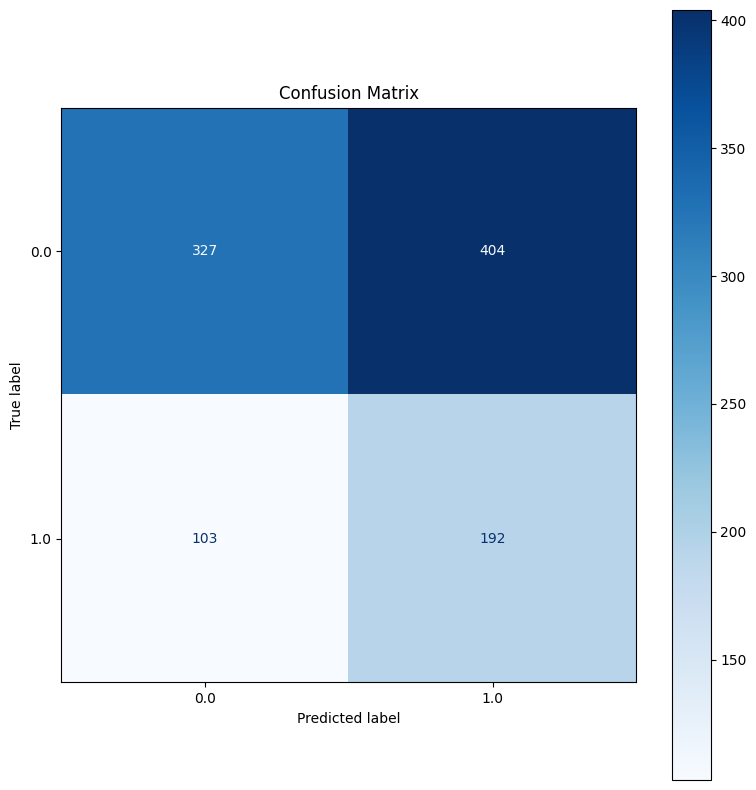

Saved confusion matrix to: outputs/01_Catboost/confusion_matrix.png


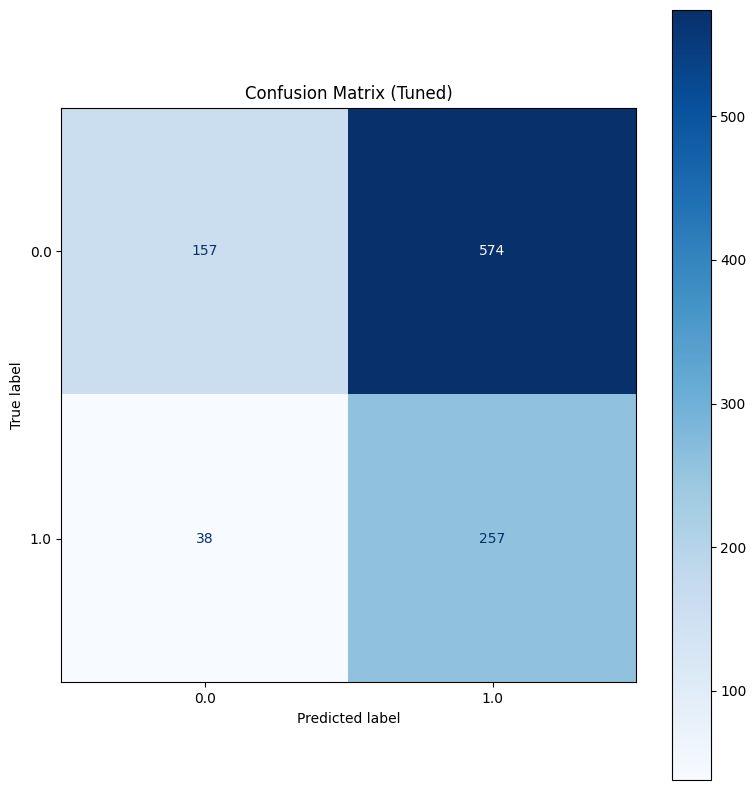

Saved tuned confusion matrix to: outputs/01_Catboost/confusion_matrix_tuned.png


In [144]:
# ==== Confusion matrix (classification) ====
if TASK_TYPE == 'classification':
    try:
        labels = np.unique(y_valid)
        fig, ax = plt.subplots(figsize=(8, 8))
        ConfusionMatrixDisplay.from_predictions(y_valid, preds, labels=labels, cmap='Blues', ax=ax)
        ax.set_title('Confusion Matrix')
        plt.tight_layout()
        cm_path = os.path.join(OUTPUT_DIR, 'confusion_matrix.png')
        plt.savefig(cm_path, dpi=200)
        plt.show()
        print(f"Saved confusion matrix to: {cm_path}")
        # Also save tuned-threshold confusion matrix if available
        try:
            if 'tuned_preds' in locals():
                fig2, ax2 = plt.subplots(figsize=(8, 8))
                ConfusionMatrixDisplay.from_predictions(y_valid, tuned_preds, labels=labels, cmap='Blues', ax=ax2)
                ax2.set_title('Confusion Matrix (Tuned)')
                plt.tight_layout()
                cm_path2 = os.path.join(OUTPUT_DIR, 'confusion_matrix_tuned.png')
                plt.savefig(cm_path2, dpi=200)
                plt.show()
                print(f"Saved tuned confusion matrix to: {cm_path2}")
        except Exception as e2:
            print(f"Could not plot tuned confusion matrix: {e2}")
    except Exception as e:
        print(f"Could not plot confusion matrix: {e}")

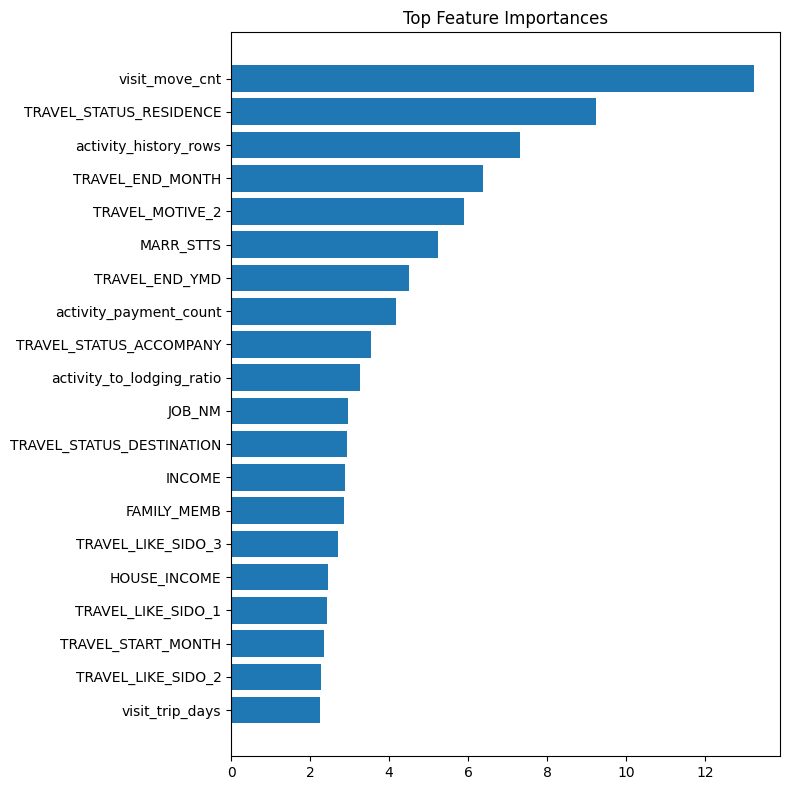

Saved feature importances plot to: outputs/01_Catboost/feature_importances_top.png


In [145]:
# ==== Feature importance ====
importances = model.get_feature_importance(type='FeatureImportance')
imp_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})
imp_df_sorted = imp_df.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(8, max(4, len(imp_df_sorted) * 0.4)))
plt.barh(imp_df_sorted['feature'][::-1], imp_df_sorted['importance'][::-1])
plt.title('Top Feature Importances')
plt.tight_layout()
out_path = os.path.join(OUTPUT_DIR, 'feature_importances_top.png')
plt.savefig(out_path, dpi=200)
plt.show()

print(f"Saved feature importances plot to: {out_path}")


## Optional: Quick parameter hints

- Increase `iterations` and adjust `learning_rate` for stronger models.
- Tune `depth` (4–10), `l2_leaf_reg`, and `border_count` for performance.
- For large data with many categories, consider `one_hot_max_size` or `max_ctr_complexity`.
